### Developing the GEO Dataset/Dataloader/Editors

In [1]:
from typing import Optional, List, Union, Tuple, Dict
from omegaconf import DictConfig
from datetime import datetime
import pandas as pd
from glob import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from rs_tools._src.datamodule.utils import split_train_val

/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
% autoreload 2

UsageError: Line magic function `%` not found.


#### Splitting the dataset based on train/val characteristics

In [2]:
list_of_dates = []
list_of_files = []
for year in [2019, 2020, 2021]:
    for month in range(1, 13):
        for day in range(1, 32):
            try:
                date = datetime(year, month, day, hour=0, minute=0, second=0).strftime('%Y%m%d%H%M%S')
                filename = f'{date}_test.nc'
                list_of_dates.append(date)
                list_of_files.append(filename)
            except ValueError:
                continue


In [3]:
split_dict = {
    "train": {"years": None, "months": [1, 3, 5, 7, 9, 11], "days": None},
    "val": {"years": None, "months": [2, 4, 6, 8, 10, 12], "days": None},
}

In [5]:
train_files, val_files = split_train_val(list_of_files, split_dict)

{'years': [2019, 2020, 2021], 'months': [1, 3, 5, 7, 9, 11], 'days': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]}
{'years': [2019, 2020, 2021], 'months': [2, 4, 6, 8, 10, 12], 'days': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]}


In [7]:
len(train_files), len(val_files), len(list_of_files)

(552, 544, 1096)

#### Loading the data

In [3]:
from rs_tools._src.utils.io import get_list_filenames

In [29]:
filenames = get_list_filenames('/Users/anna.jungbluth/Desktop/git/rs_tools/data/msg/analysis', 'nc')

In [30]:
ds: xr.Dataset = xr.load_dataset(filenames[0], engine="netcdf4")

In [31]:
ds

<xarray.Dataset>
Dimensions:          (y: 256, x: 256, band: 11, time: 1, band_wavelength: 11)
Coordinates:
  * y                (y) float64 -1.449e+06 -1.446e+06 ... -6.871e+05 -6.841e+05
  * x                (x) float64 -5.137e+06 -5.134e+06 ... -4.375e+06 -4.372e+06
    cloud_mask       (y, x) float64 3.0 3.0 3.0 3.0 3.0 ... 2.0 1.0 1.0 2.0 2.0
    latitude         (y, x) float64 -15.0 -14.99 -14.98 ... -6.611 -6.61 -6.61
    longitude        (y, x) float64 -69.95 -69.79 -69.63 ... -47.23 -47.19
  * band             (band) object 'IR_016' 'IR_039' ... 'WV_062' 'WV_073'
  * time             (time) object '2020-10-01 15:00:00'
  * band_wavelength  (band_wavelength) float64 1.64 3.92 8.7 ... 0.81 6.25 7.35
Data variables:
    Rad              (band, y, x) float32 6.98 6.24 6.448 ... 14.44 14.25 14.33

In [48]:
data = ds.Rad.to_numpy()

In [33]:
band_wavelengths = ds.band_wavelength.compute().to_numpy()
band_wavelengths

array([ 1.64,  3.92,  8.7 ,  9.66, 10.8 , 12.  , 13.4 ,  0.64,  0.81,
        6.25,  7.35])

##### Testing GeoDataset

In [3]:
from rs_tools._src.datamodule.datasets import GeoDataset

In [4]:
splits_dict = { 
    "train": {"years": None, "months": None, "days": None},
    "val": {"years": None, "months": [2, 4, 6, 8, 10, 12], "days": None},
}

In [5]:
geo = GeoDataset(
    data_dir='/Users/anna.jungbluth/Desktop/git/rs_tools/data/goes16/analysis',
    editors=None,
    splits_dict=splits_dict['train'],
    load_coords=True,
    load_cloudmask=True,
)

2024-04-21 17:55:25.430 | INFO     | rs_tools._src.datamodule.utils:get_split:47 - No years specified for split. Using all years.
2024-04-21 17:55:25.431 | INFO     | rs_tools._src.datamodule.utils:get_split:50 - No months specified for split. Using all months.
2024-04-21 17:55:25.432 | INFO     | rs_tools._src.datamodule.utils:get_split:53 - No days specified for split. Using all days.


In [12]:
for i in range(2):
    print(geo[i]['wavelengths'])

[ 0.47  0.64  0.87  1.38  1.61  2.25  3.89  6.17  6.93  7.34  8.44  9.61
 10.33 11.19 12.27 13.27]
[ 0.47  0.64  0.87  1.38  1.61  2.25  3.89  6.17  6.93  7.34  8.44  9.61
 10.33 11.19 12.27 13.27]


##### Testing Editors

In [6]:
from rs_tools._src.datamodule.editor import BandSelectionEditor, NanMaskEditor, CoordNormEditor, NanDictEditor, RadUnitEditor, ToTensorEditor, StackDictEditor
from iti.data.editor import NanEditor, RandomPatchEditor, BrightestPixelPatchEditor
from rs_tools._src.geoprocessing.units import convert_units
from rs_tools import MODIS_WAVELENGTHS, GOES_WAVELENGTHS, MSG_WAVELENGTHS

/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F75BB06B-2723-344D-99CE-9CB8BB94077A> /opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [7]:
i = 0

In [29]:
editor = ToTensorEditor()

ITI/Helio Patching works for full-disk images

In [23]:
editor = BrightestPixelPatchEditor(patch_shape=(256, 256))

In [24]:
data = editor.call(geo[i]["data"])
data.shape

(16, 256, 256)

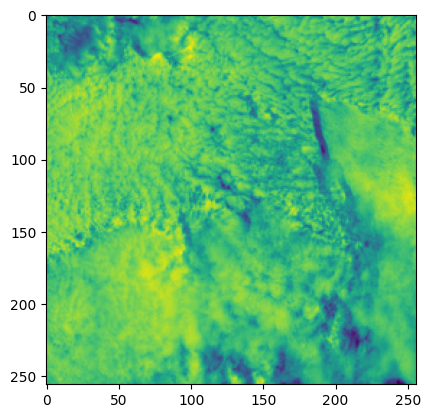

In [26]:
plt.imshow(data[0])